In [1]:
import torch
import torch.nn as nn
import torchvision
from datasets import load_dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
config = {
    'num_rows': 2000,
    'image_size': 64
}

label_dict = {
    0: 'Annual Crop',
    1: 'Forest',
    2: 'Herbaceous Vegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'Permanent Crop',
    7: 'Residential',
    8: 'River',
    9: 'Sea/Lake'
}


In [3]:
# Load the huggingface dataset
dataset = load_dataset('jonathan-roberts1/EuroSAT')

In [4]:
#select subset of data and shuffle 
dataset = dataset['train'].shuffle(seed=42).select(range(config['num_rows']))

In [5]:
#Split into train and test+validation
train_test_valid = dataset.train_test_split(test_size=0.2, seed=42)
train_data = train_test_valid['train']
test_valid_dataset = train_test_valid['test']

#Split the test+validation set into test and validation
test_valid_split = test_valid_dataset.train_test_split(test_size=0.5, seed=42)
test_data = test_valid_split['test']
val_data = test_valid_split['train']

# Check sizes of the splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 1600
Validation set size: 200
Test set size: 200


In [6]:
#create dataset class
class EuroSATDataset(Dataset):
    def __init__(self, hf_dataset, transform = None):
        self.data = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        label = torch.tensor(item['label'], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

data_transform = transforms.Compose([
    transforms.Resize((config['image_size'], config['image_size'])),
    transforms.ToTensor()])
    

In [7]:
train_dataset = EuroSATDataset(train_data, data_transform)
val_dataset = EuroSATDataset(val_data, data_transform)
test_dataset = EuroSATDataset(test_data, data_transform)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

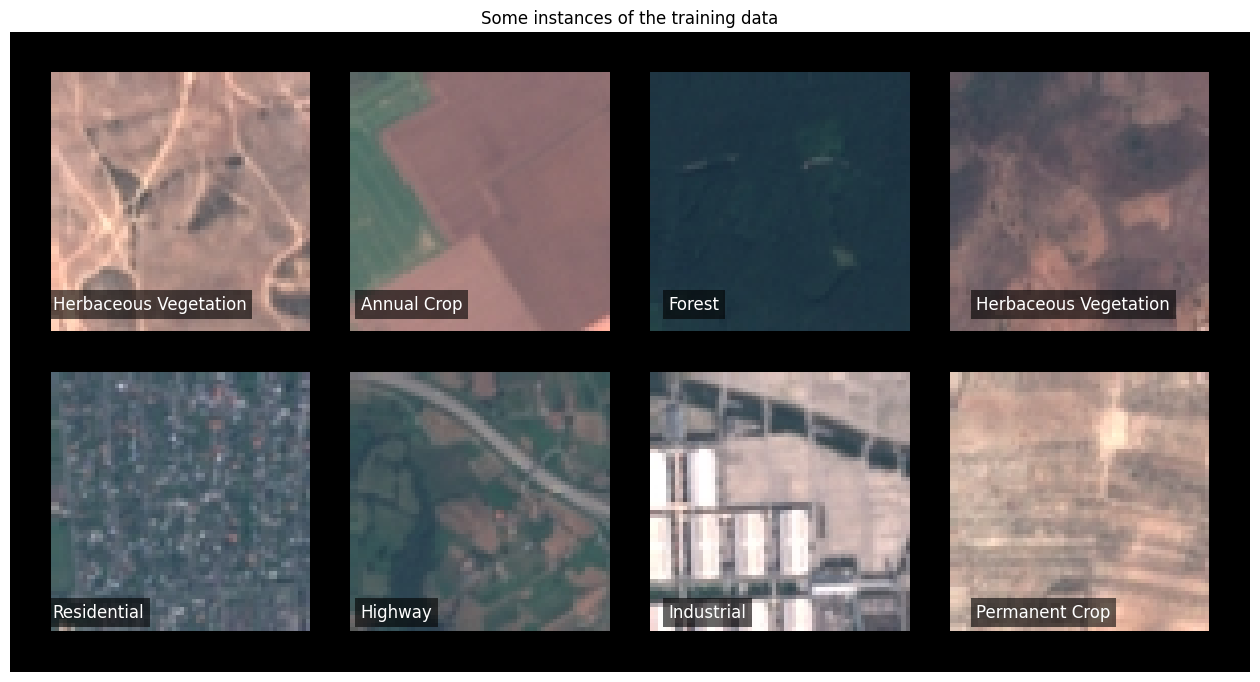

In [10]:
# Display the images
images, labels = next(iter(train_dataloader))
plt.figure(figsize=(16, 24))
grid_imgs = torchvision.utils.make_grid(images[:8], nrow=4, padding=10)
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1, 2, 0)))

# Add labels for each image
for i in range(8): 
    plt.text(
        x=10 + (i % 4) * (grid_imgs.shape[2] // 4),  
        y=grid_imgs.shape[1] - 90 + (i // 4) * (grid_imgs.shape[2] // 4),  
        s=label_dict[labels[i].item()],  
        color="white",
        fontsize=12,
        bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'),
    )
plt.title('Some instances of the training data')
plt.axis("off")
plt.show()

In [24]:
#singe kernel application function
def apply_kernel(input_slice, weigths, bias):
    s = input_slice*weigths
    Z = torch.sum(s) + bias
    Z = torch.tensor(Z, dtype=torch.float32)
    return Z

#slice kernel function over inputs
def slice_over_input(inputs, stride, weigths, bias):

    #get dimensions of inputs
    C_in, H_in, W_in = inputs.shape[0] , inputs.shape[1], inputs.shape[2]

    f = weigths.shape[1]

    H_out = (H_in - f)//stride + 1
    W_out = (W_in - f)//stride + 1

    Z = torch.zeros(1, H_out, W_out)

    for h in range(H_out):
        vert_start = h
        vert_end = h + f

        for w in range(W_out):
            horiz_start = w
            horiz_end = w + f

            current_slice = inputs[: , horiz_start:horiz_end, vert_start:vert_end]
            Z[0, h, w] = apply_kernel(current_slice, weigths, bias)
    
    return Z

    

In [26]:
weights = torch.tensor(np.random.rand(3,3,3), dtype=torch.float32)
image, label = next(iter(train_dataloader))

inputs = image[0]

output = slice_over_input(inputs, 1, weights, 0)

print("Input shape:", inputs.shape)
print("Kernel shape:", weights.shape)
print("Output shape:", output.shape)
print("Output tensor:", output)

C:\Users\alexa\AppData\Local\Temp\ipykernel_27304\2907314611.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z = torch.tensor(Z, dtype=torch.float32)


Input shape: torch.Size([3, 64, 64])
Kernel shape: torch.Size([3, 3, 3])
Output shape: torch.Size([1, 62, 62])
Output tensor: tensor([[[3.6885, 3.5513, 3.7257,  ..., 4.4716, 4.3081, 4.3049],
         [3.9403, 3.9533, 4.3458,  ..., 4.5788, 4.5462, 4.5913],
         [4.3170, 4.5559, 5.1025,  ..., 4.6692, 4.7287, 4.6777],
         ...,
         [3.1628, 3.2596, 3.5946,  ..., 4.9136, 4.4638, 4.3740],
         [3.4396, 3.6407, 4.1581,  ..., 4.5626, 4.2443, 4.3685],
         [4.0114, 4.3037, 4.7819,  ..., 4.4957, 4.2362, 4.4321]]])
